In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def Simulate(watering_ammount, threshold, current_val, condition):
    top = current_val + watering_ammount
    s = top
    S = [s]
    i = 0
    while(s > threshold):
        #condition = cond(i, 200)
        s -= 0.01*s*condition + (np.random.rand()-0.5)*0.03
        S.append(s)
        i+=1
    return (S)


def SimulatePeriod(watering_ammount, period, current_val):
    top = current_val + watering_ammount
    s = top
    S = [s]
    for i in range(period):
        #condition = cond(i, 200)
        s -= 0.01*s + (np.random.rand()-0.5)*0.03
        S.append(s)
        i+=1
    return (S)


In [ ]:
threshold = 0.5
true_threshold = 0.1
current_val = 1
condition = 1
watering_ammount = 0.5

stream = []
T = [threshold]
for i in range(15):
    S = Simulate(watering_ammount, threshold, current_val, condition)
    current_val = S[-1] + watering_ammount
    T = np.concatenate([T, [threshold]*len(S)])
    if(threshold > true_threshold):
        threshold -= 0.2*threshold
    elif(threshold < true_threshold):
        threshold += 0.2*threshold
    
        
    stream = np.concatenate([stream, S])


fig, ax = plt.subplots(figsize = (15, 5))
ax.hlines(true_threshold, 0, len(stream), color = 'r', linestyles='dashed')
plt.plot(T)
ax.plot(stream)

(0.0, 100.0)

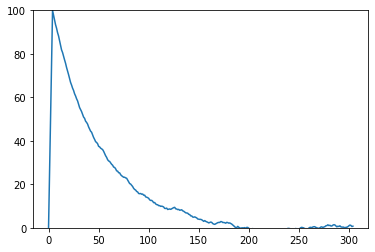

In [18]:
def cond(i, T, period):
    con = T*np.sin(np.pi*i/period)**2 +0.5
    return(con)

def SimulateSteps(watering_ammount, current_val, T):
    top = current_val + watering_ammount
    s = top
    S = np.linspace(current_val, top, 5)
    for i in range(300):
        condition = cond(i, T,  300)
        s -= 0.02*s + (np.random.rand()-0.5)
        S = np.concatenate([S, [s]])
        
    return (S)

plt.plot(SimulateSteps(100,0, 1))
plt.ylim([0, 100])

In [19]:
x_train = []
y_train = []

for i in range(10000):
    WA = 100*np.random.rand()
    current = 100*np.random.rand()
    T = 1
    x_train.append([WA, current, T])
    y_train.append(SimulateSteps(WA, current, T))
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(3,activation='relu'))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(305, activation='relu'))

model.compile(optimizer =tf.keras.optimizers.Adam(lr = 0.001, beta_1 = 0.95), loss = 'mse')

batch_size = 10
model.fit(x_train,y_train, epochs =30, batch_size = batch_size, validation_data = None, verbose = 1)

Epoch 1/30
1000/1000 [==============================] - 3s 2ms/step - loss: 261.3435
Epoch 2/30
1000/1000 [==============================] - 2s 2ms/step - loss: 30.1657
Epoch 3/30
1000/1000 [==============================] - 2s 2ms/step - loss: 7.3263
Epoch 4/30
1000/1000 [==============================] - 1s 1ms/step - loss: 7.0640
Epoch 5/30
1000/1000 [==============================] - 1s 1ms/step - loss: 7.2279
Epoch 6/30
1000/1000 [==============================] - 1s 1ms/step - loss: 7.1937
Epoch 7/30
1000/1000 [==============================] - 1s 1ms/step - loss: 6.9126
Epoch 8/30
1000/1000 [==============================] - 1s 1ms/step - loss: 6.9089
Epoch 9/30
1000/1000 [==============================] - 1s 1ms/step - loss: 7.0421
Epoch 10/30
1000/1000 [==============================] - 2s 1ms/step - loss: 7.3170
Epoch 11/30
1000/1000 [==============================] - 2s 2ms/step - loss: 6.7409
Epoch 12/30
1000/1000 [==============================] - 2s 2ms/step - loss: 6.716

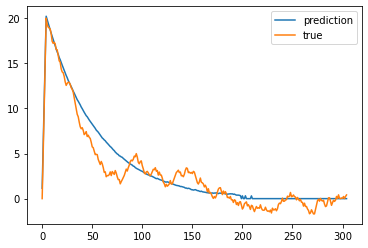

In [29]:
WA =20
curr = 0
T = 1

y_pred = model.predict(np.atleast_2d([WA, curr, T]))
plt.plot(y_pred[0], label = 'prediction')
plt.plot(SimulateSteps(WA, curr, T), label = 'true')
plt.legend()

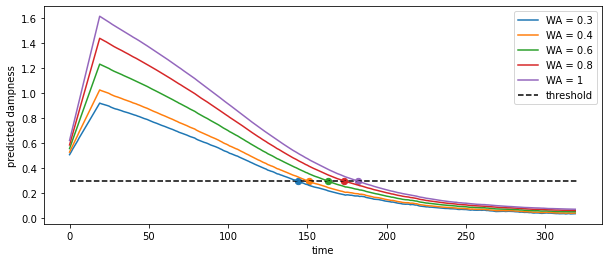

In [43]:
curr = 0.6
threshold = 0.3
fig, ax = plt.subplots(figsize = (10, 4))
for WA in [0.3, 0.4, 0.6, 0.8, 1]:
    T = 1
    y_pred = model.predict(np.atleast_2d([WA, curr, T]))
    ax.plot(y_pred[0], label = 'WA = ' +str(WA))
    ax.scatter(len(y_pred[y_pred>=threshold]), threshold, s = 40)
    
ax.hlines(threshold, 0, 320, color = 'k', linestyles='dashed', label = 'threshold')



ax.set_xlabel('time')
ax.set_ylabel('predicted dampness')
plt.legend()

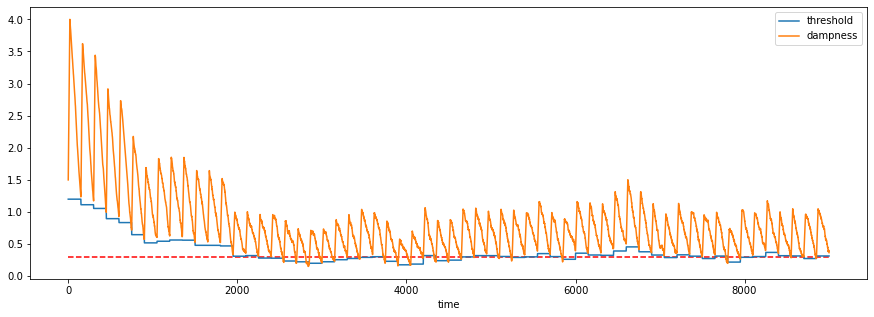

In [45]:
#simulation of feedback looop and forecasting combined

Period = 150           #period of plant watering
current_dampness = 1.5 #starting dampness
true_th = 0.3          #true threshold -> if we miss it we get feedback to correct the estimated threshold
estimated_th = 1.2     #starting estimation is higher than the true threshold
num_cycles = 60        #number of periods to simulate

S = []
thresholds = []
WAs = []
fig, ax = plt.subplots(figsize = (15, 5))

errors = []           #track forecast errors

for i in range(num_cycles):
    T = 1
    Ts = []
    for j in np.linspace(0.3, 2.5, 20):
        #forecasts for different WA
        y_pred = model.predict(np.atleast_2d([j, current_dampness, T]))[0]
        t = len(y_pred[y_pred>=estimated_th])
        Ts.append(t)
     
    #Choose the WA, which reaches the threshold closest to the target time
    WA = np.linspace(0.3, 2.5, 20)[np.argmin(np.abs(np.array(Ts) - Period))]
    WAs.append(WA)
    
    #simulate the chosen WA
    S = np.concatenate([S, SimulateSteps(WA, current_dampness, T)[:Period]])
    
    current_dampness = S[-1]
    thresholds = np.append(thresholds, np.repeat(estimated_th, Period))
    
    errors.append(S[-1] - estimated_th)
    
    #correct the estimated threshold based on the feedback info
    if(S[-1] > true_th):
        estimated_th = S[-1]*0.9
    else:
        estimated_th = S[-1]*1.1

ax.plot(thresholds, label = 'threshold')
ax.plot(S, label = 'dampness')
ax.set_xlabel('time')
ax.hlines(true_th, 0, 9000, color = 'r', linestyle = '--')
plt.legend()


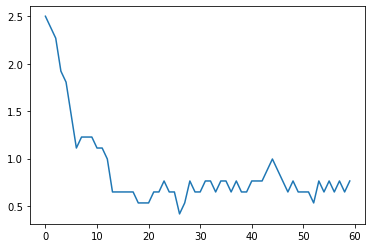

In [46]:
#If all is right, the WA's decrease and converge to final (optimal) value
plt.plot(WAs)

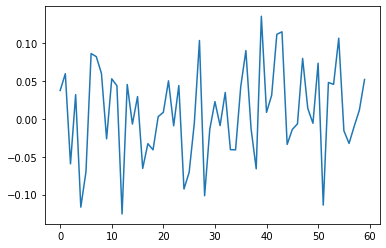

In [47]:
#errors in each cycle
plt.plot(errors)

WA: 31.313131313131315
time: 52


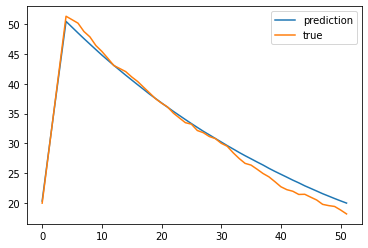

In [41]:
Loss = lambda WA, time: 1*WA - 1*time

current_dampness = 20
estimated_th = 20

WAs = np.linspace(0, 100, 100)
Times = []
Losses = []

#Get the loss for all possible watering ammounts
for i in WAs:
    y_pred = model.predict(np.atleast_2d([i, current_dampness, T]))[0]
    t = len(y_pred[y_pred>=estimated_th])
    Times.append(t)
    Losses.append(Loss(i, t))

#choose the minimal loss        
idx = np.argmin(Losses)
WA = WAs[idx]
time = Times[idx]

print("WA: " + str(WA))
print("time: " + str(time))

y_pred = model.predict(np.atleast_2d([WA, current_dampness, T]))
plt.plot(y_pred[0][:time], label = 'prediction')
plt.plot(SimulateSteps(WA, current_dampness, T)[:time], label = 'true')
plt.legend()

Text(0, 0.5, 'Loss')

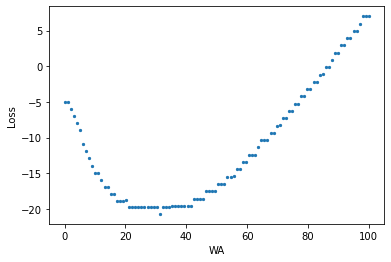

In [45]:
plt.scatter(WAs, Losses, s = 5)
plt.xlabel('WA')
plt.ylabel('Loss')